In [1]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import feature   
from itertools import chain

import skimage
from skimage.feature import hog
from skimage import data, exposure, io, color

from sklearn.datasets import fetch_lfw_people
from PIL import Image
from skimage import data, transform
from sklearn.feature_extraction.image import PatchExtractor

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 

from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.image as mpimg

import cv2

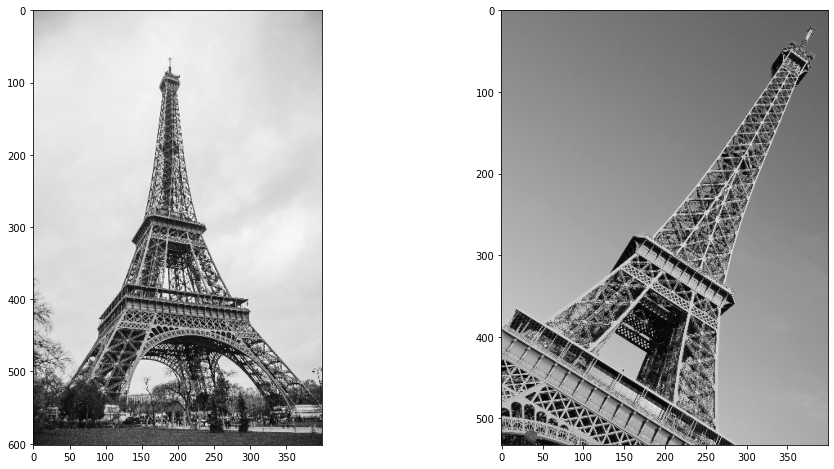

In [2]:
img1 = cv2.imread('data/labeling3/eiffel_1.jpg')  
img2 = cv2.imread('data/labeling3/eiffel_2.jpg')  

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

figure, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')

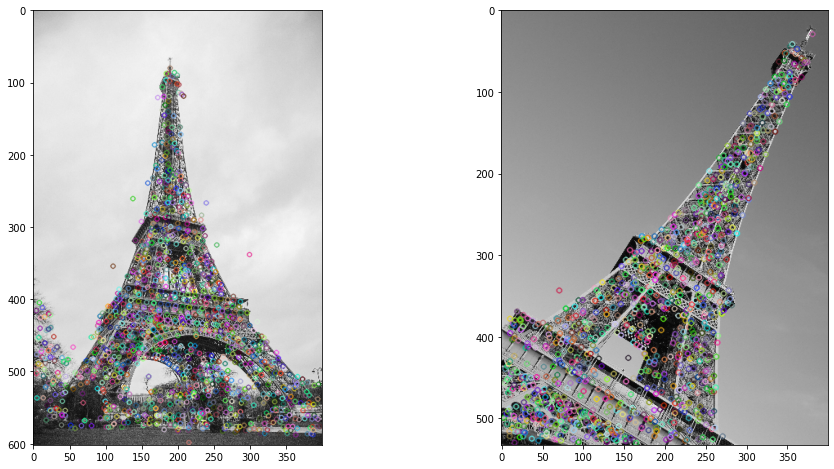

In [3]:
img1 = cv2.imread('data/labeling3/eiffel_1.jpg')  
img2 = cv2.imread('data/labeling3/eiffel_2.jpg')  

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1)
img_2 = cv2.drawKeypoints(gray2,keypoints_2,img2)

figure, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img_1)
ax[1].imshow(img_2)

In [4]:
def drawMatches(path1, path2, ratio=0.7):
    img1 = cv2.imread(path1)  
    img2 = cv2.imread(path2)  
    
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    #keypoints
    keyDetector = cv2.SIFT_create()
    keypoints_1, descriptors_1 = keyDetector.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = keyDetector.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(descriptors_1,descriptors_2,k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < ratio*n.distance:
            matchesMask[i]=[1,0]

    draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

    img_3 = cv2.drawMatchesKnn(img1,keypoints_1,img2,keypoints_2,matches,None,**draw_params)

    figure, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(img_3)

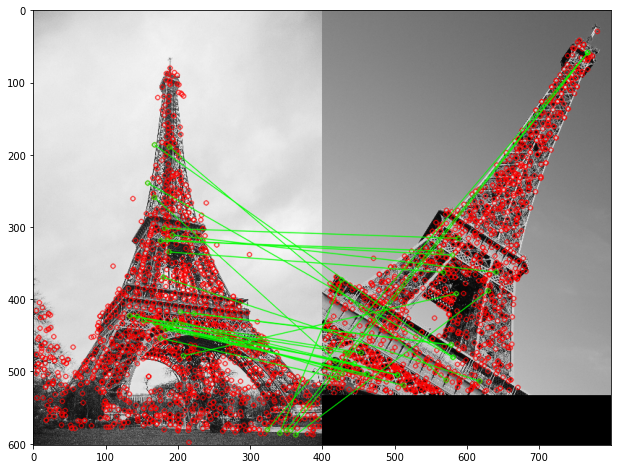

In [5]:
drawMatches('data/labeling3/eiffel_1.jpg', 'data/labeling3/eiffel_2.jpg', ratio=0.8)

# Testes com imagem

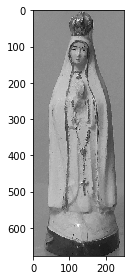

In [6]:
img_base = cv2.imread('data/labeling3/imagem_base.jpg') 
img_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2GRAY)

io.imshow(img_base)

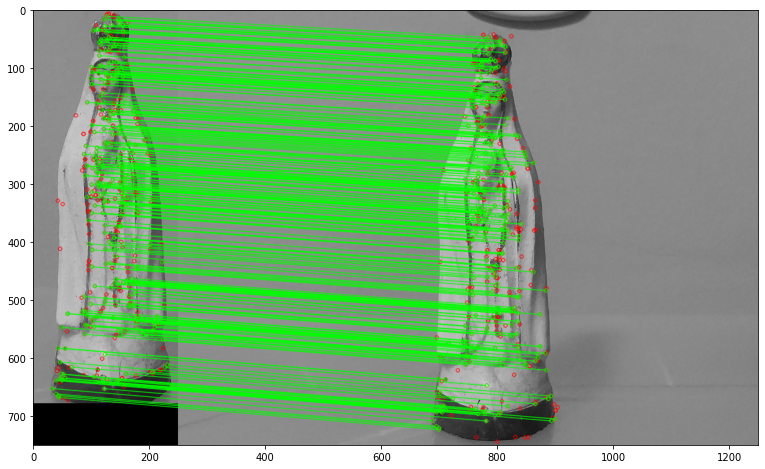

In [7]:
drawMatches('data/labeling3/imagem_base.jpg', 'data/labeling3/imagem_1.jpg')

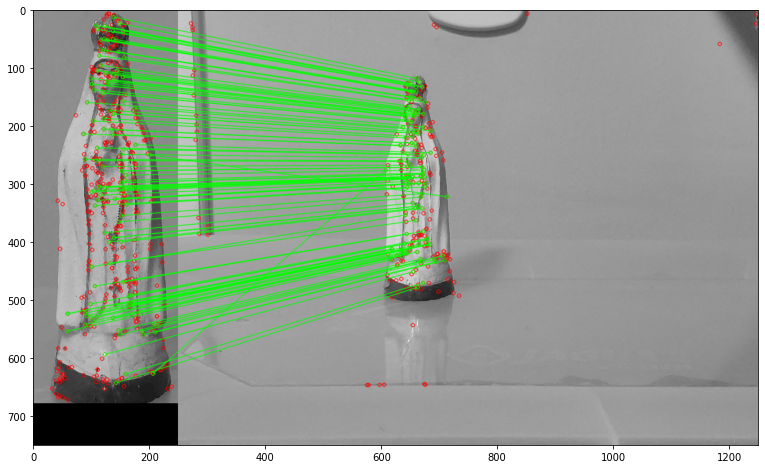

In [8]:
drawMatches('data/labeling3/imagem_base.jpg', 'data/labeling3/imagem_2.jpg')

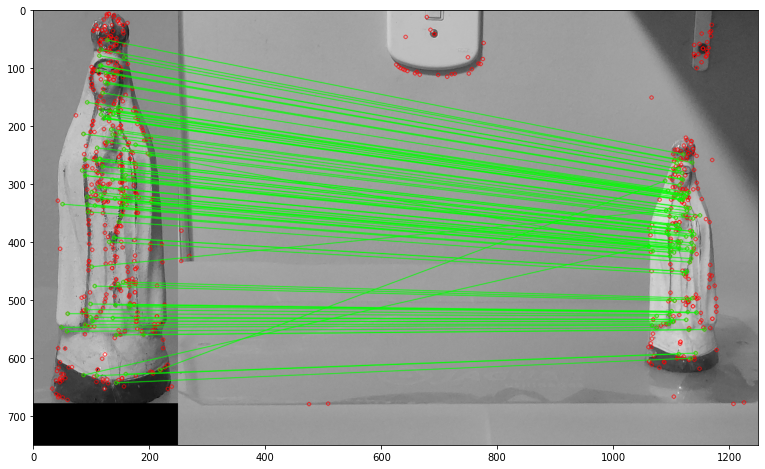

In [9]:
drawMatches('data/labeling3/imagem_base.jpg', 'data/labeling3/imagem_3.jpg')

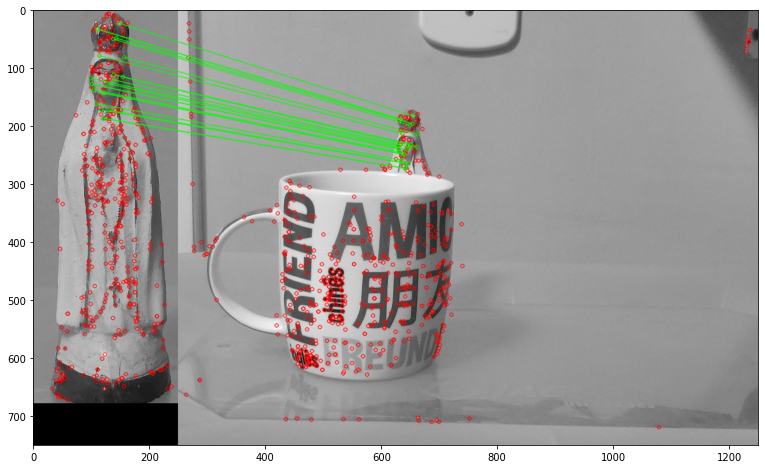

In [10]:
drawMatches('data/labeling3/imagem_base.jpg', 'data/labeling3/imagem_4.jpg', ratio=0.6)

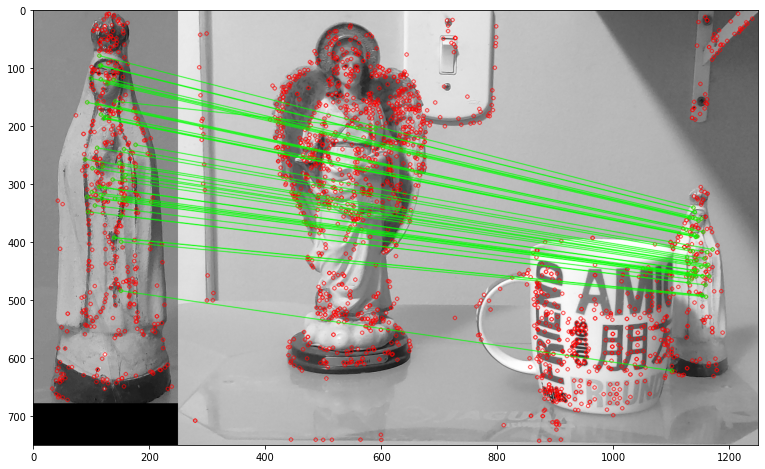

In [11]:
drawMatches('data/labeling3/imagem_base.jpg', 'data/labeling3/imagem_5.jpg')

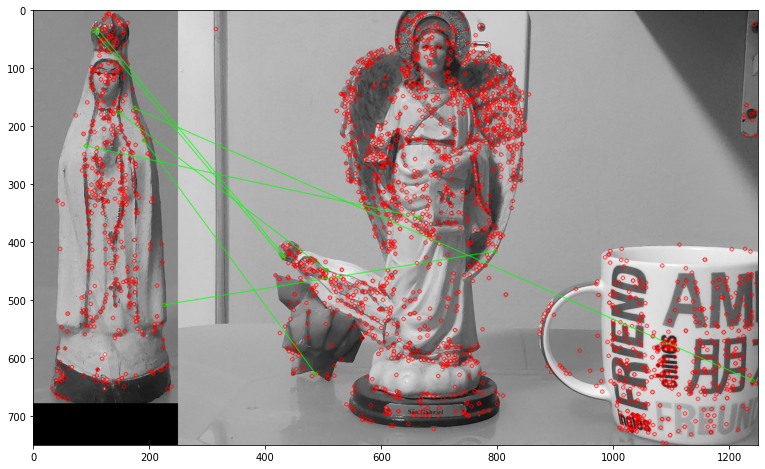

In [12]:
drawMatches('data/labeling3/imagem_base.jpg', 'data/labeling3/imagem_6.jpg', ratio=.7)

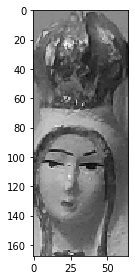

In [13]:
img_base = cv2.imread('data/labeling3/imagem_base_rosto.jpg') 
img_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2GRAY)
io.imshow(img_base)

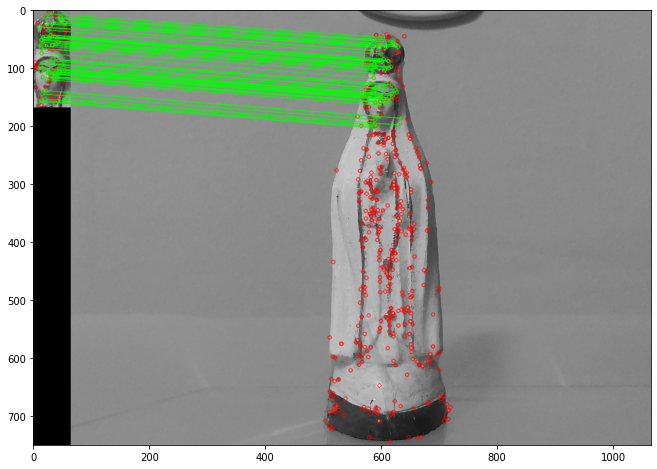

In [14]:
drawMatches('data/labeling3/imagem_base_rosto.jpg', 'data/labeling3/imagem_1.jpg')

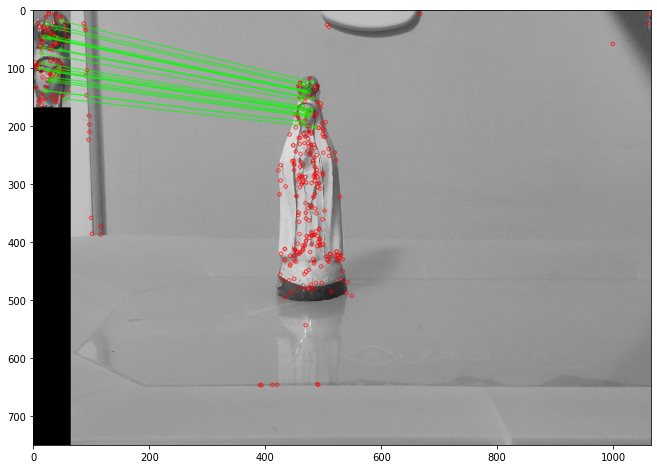

In [15]:
drawMatches('data/labeling3/imagem_base_rosto.jpg', 'data/labeling3/imagem_2.jpg')

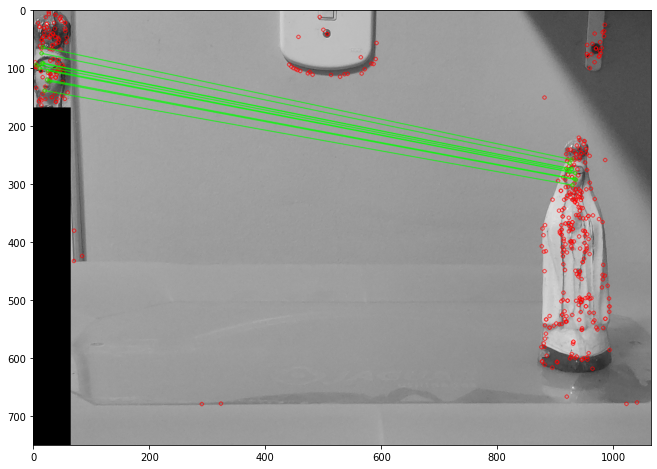

In [16]:
drawMatches('data/labeling3/imagem_base_rosto.jpg', 'data/labeling3/imagem_3.jpg')

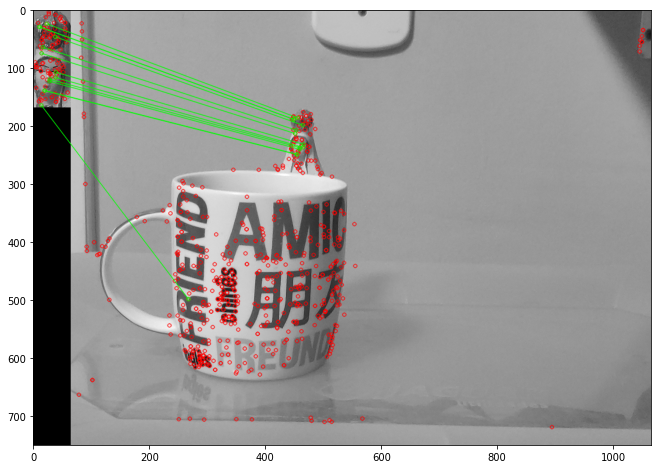

In [17]:
drawMatches('data/labeling3/imagem_base_rosto.jpg', 'data/labeling3/imagem_4.jpg')

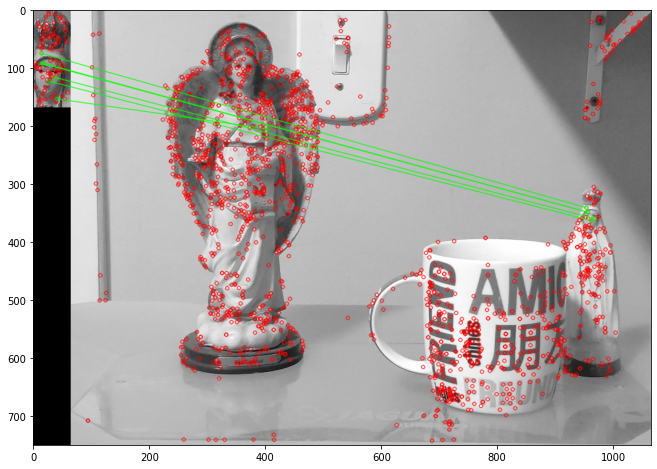

In [18]:
drawMatches('data/labeling3/imagem_base_rosto.jpg', 'data/labeling3/imagem_5.jpg')

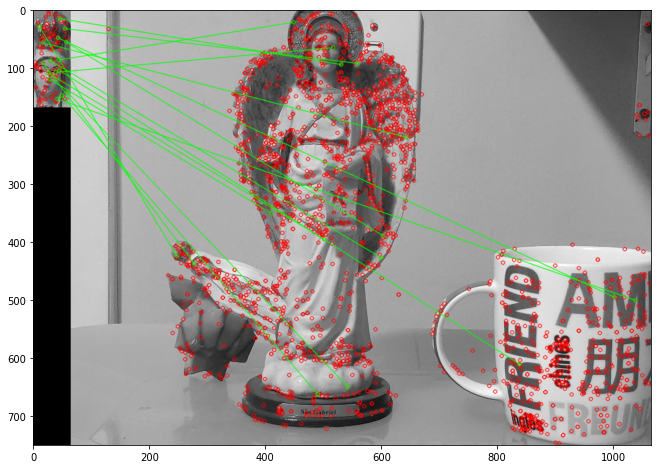

In [19]:
drawMatches('data/labeling3/imagem_base_rosto.jpg', 'data/labeling3/imagem_6.jpg', ratio=0.9)

## Fazendo panoramica

In [20]:
def get_sift_keypoints(image):
    sift_cv2 = cv2.xfeatures2d.SIFT_create()
    keypoints = sift_cv2.detect(image, None)
    return keypoints


def stitch_images(input_left, input_right, ratio=0.7):
    status, H = match(input_left.copy(), input_right.copy(), ratio=ratio)

    if status:
        outputImage = cv2.warpPerspective(input_right, H, (input_left.shape[1] + input_right.shape[1], input_left.shape[0]))
        outputImage[0:input_left.shape[0], 0:input_left.shape[1]] = input_left
    return True, outputImage


def match(image_left, image_right, ratio=0.7):
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=0, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    sift = cv2.xfeatures2d.SIFT_create()

    image_left_gray = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)
    image_right_gray = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)

    keypoints_left, descriptors_left = sift.detectAndCompute(image_left_gray, None)
    keypoints_right, descriptors_right = sift.detectAndCompute(image_right_gray, None)

    matches = flann.knnMatch(descriptors_right, descriptors_left, k=2)

    # Ratio test
    good = []
    for i, (m, n) in enumerate(matches):
        if m.distance < ratio * n.distance:
            good.append((m.trainIdx, m.queryIdx))

    if len(good) > 4:
        pointsCurrent = keypoints_right
        pointsPrevious = keypoints_left

        matchedPointsCurrent = np.float32([pointsCurrent[i].pt for (__, i) in good])
        matchedPointsPrev = np.float32([pointsPrevious[i].pt for (i, __) in good])

        H, s = cv2.findHomography(matchedPointsCurrent, matchedPointsPrev, cv2.RANSAC, 4)
        return True, H
    else:
        return False, None

In [21]:
def view_sift_keypoints(firstImage, secondImage):
        zero = np.array([0])

        keypoint_left = get_sift_keypoints(firstImage)
        keypoint_right = get_sift_keypoints(secondImage)

        keypoint_left_image = np.zeros_like(firstImage)
        keypoint_right_image = np.zeros_like(secondImage)
        keypoint_left_image = cv2.drawKeypoints(firstImage, 
                                                keypoint_left, 
                                                keypoint_left_image)
        keypoint_right_image = cv2.drawKeypoints(secondImage, 
                                                keypoint_right, 
                                                keypoint_right_image)

        # Plot input images with keypoints marked
        fig = plt.figure(figsize=(10, 20))

        fig.add_subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(keypoint_left_image, cv2.COLOR_BGR2RGB))
        plt.title('Input image left')

        fig.add_subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(keypoint_right_image, cv2.COLOR_BGR2RGB))
        plt.title('Input image right')

        plt.show()

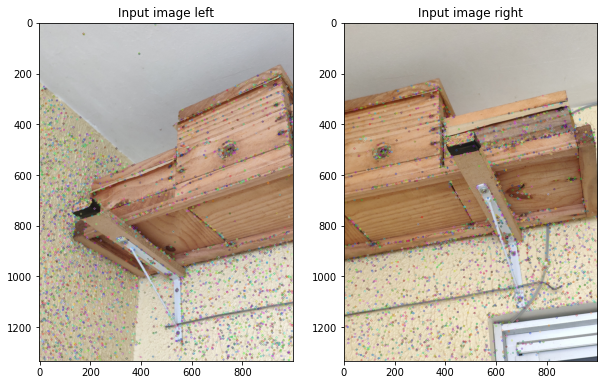

In [22]:
img1 = cv2.imread('data/labeling3/panoramic_1.jpg')  
img2 = cv2.imread('data/labeling3/panoramic_2.jpg')  

view_sift_keypoints(img1, img2)

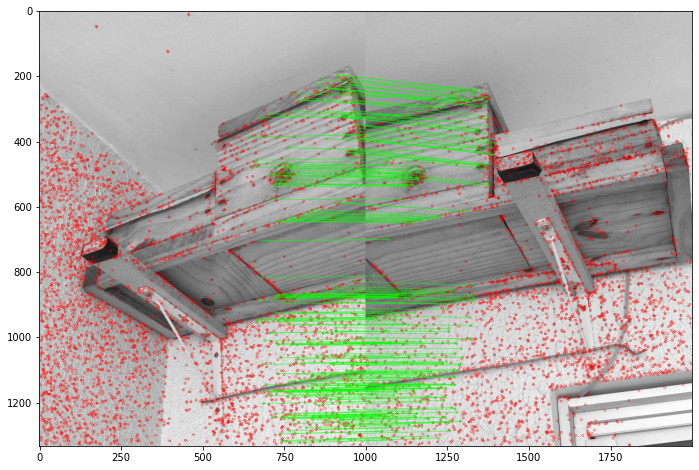

In [23]:
drawMatches('data/labeling3/panoramic_1.jpg', 'data/labeling3/panoramic_2.jpg', ratio=0.5)

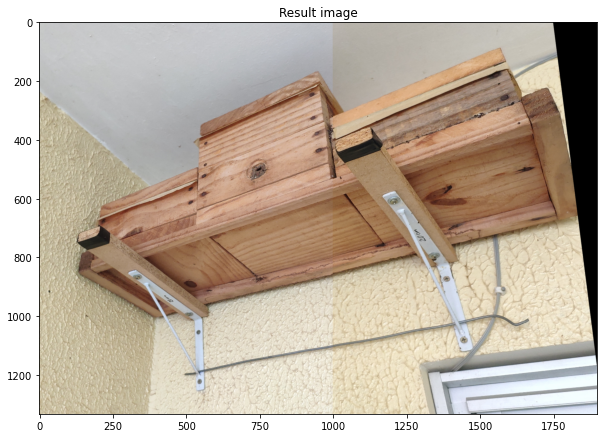

In [24]:
canMerge, result = stitch_images(img1, img2, ratio=0.6)

if canMerge:
    # Plot input images with keypoints marked
        fig = plt.figure(figsize=(10, 20))      
        plt.imshow(cv2.cvtColor(result[:,:1900], cv2.COLOR_BGR2RGB))
        plt.title('Result image')
        plt.show()